# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Directories

In [2]:
os.chdir("..")
print(os.getcwd())

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/Assignment-1


In [3]:
DATA_DIR = os.path.join(os.getcwd(), "data")
print(DATA_DIR)

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/Assignment-1/data


# The data

In [4]:
file_name = "assignment1_dev_set.csv"

df = pd.read_csv(os.path.join(DATA_DIR, file_name), index_col=0)
cols = df.columns

In [5]:
display(cols)

Index(['Project ID', 'Experiment type', 'Sex', 'Host age', 'BMI',
       'Disease MESH ID', 'Acholeplasma axanthum',
       'Acidaminococcus fermentans', 'Acidaminococcus intestini',
       'Actinomyces lingnae',
       ...
       'Clostridium sphenoides', 'Clostridium spiroforme',
       'Clostridium stercorarium', 'Clostridium symbiosum',
       'Clostridium thermosuccinogenes', 'Clostridium xylanolyticum',
       'Eubacterium brachy', 'Eubacterium dolichum', 'Eubacterium sulci',
       'Ruminococcus gnavus'],
      dtype='object', length=140)

We can see that the `BMI` column is the 6<sup>th</sup> one and the bacterial concentrations start from the 8<sup>th</sup> column up to the last (141<sup>st</sup>)  
Also, since we want to classify `BMI` based **only** on the bacteria in the gut microbiome, we can **exclude** the following columns:
- `Project ID`
- `Experiment type`
- `Disease MESH ID`

Regarding the `Sex` and `Host age` columns, I decided to separate them in order to examine them one by one, and not with the bacterial data.

In [6]:
# drop columns Project ID, Experiment type, Sex, Host age, Disease MESH ID
cols_to_drop = [
    "Project ID",
    "Experiment type",
    "Sex",
    "Host age",
    "BMI",
    "Disease MESH ID"
]

bmi = df["BMI"]
sex = df["Sex"]
age = df["Host age"]
bacteria = df.drop(cols_to_drop, axis=1)

In [7]:
bacteria.head()

,Acholeplasma axanthum,Acidaminococcus fermentans,Acidaminococcus intestini,Actinomyces lingnae,Akkermansia muciniphila,Alistipes finegoldii,Alistipes indistinctus,Alistipes obesi,Alistipes onderdonkii,Alistipes putredinis,...,Clostridium sphenoides,Clostridium spiroforme,Clostridium stercorarium,Clostridium symbiosum,Clostridium thermosuccinogenes,Clostridium xylanolyticum,Eubacterium brachy,Eubacterium dolichum,Eubacterium sulci,Ruminococcus gnavus
0,0.000000,0.000000,0.000000,0.000000,0.017674,0.000000,0.00000,0.0,0.117827,0.005891,...,0.005891,0.029457,0.000000,0.000000,0.002946,0.000000,0.000000,0.000000,0.002946,0.100153
1,0.001028,0.000000,0.000000,0.000000,13.015800,0.001542,0.00000,0.0,0.073486,0.403916,...,0.000000,0.002569,0.412652,0.003083,0.000000,0.000000,0.008736,0.014903,0.077597,0.004625
2,0.001406,0.000000,0.000000,0.001406,0.002812,0.201074,0.00000,0.0,0.043590,0.105459,...,0.000000,0.005624,0.002812,0.007031,0.000000,0.000000,0.000000,0.000000,0.005624,0.016873
3,0.000000,0.008825,0.273562,0.000000,0.044123,0.004412,0.34857,0.0,0.026474,0.586834,...,0.017649,0.198553,0.000000,0.158842,0.030886,0.101483,0.000000,0.000000,0.000000,0.000000
4,0.002878,0.037419,7.359970,0.000000,0.872143,0.000000,0.00000,0.0,1.732770,1.004550,...,0.305106,0.135283,0.000000,0.051811,0.054689,0.083473,0.020148,0.000000,0.054689,0.011513


## General Statistics

### BMI

In [16]:
def plot_kde(
        df,
        title="Kernel Density Estimation",
        x_label="Values",
        y_label="Frequency",
        color_by_sex=None
    ):

    plt.figure(figsize=(10, 7))
    # sns.histplot(
    #     df, bins=20, kde=True
    # )

    if isinstance(color_by_sex, pd.Series) or isinstance(color_by_sex, pd.DataFrame):
        data = pd.DataFrame({"BMI": df, "Sex": color_by_sex})
        sns.histplot(data=data, x="BMI", bins=20, kde=True, hue="Sex", alpha=0.6)
    else:
        sns.histplot(df, bins=20, kde=True)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()

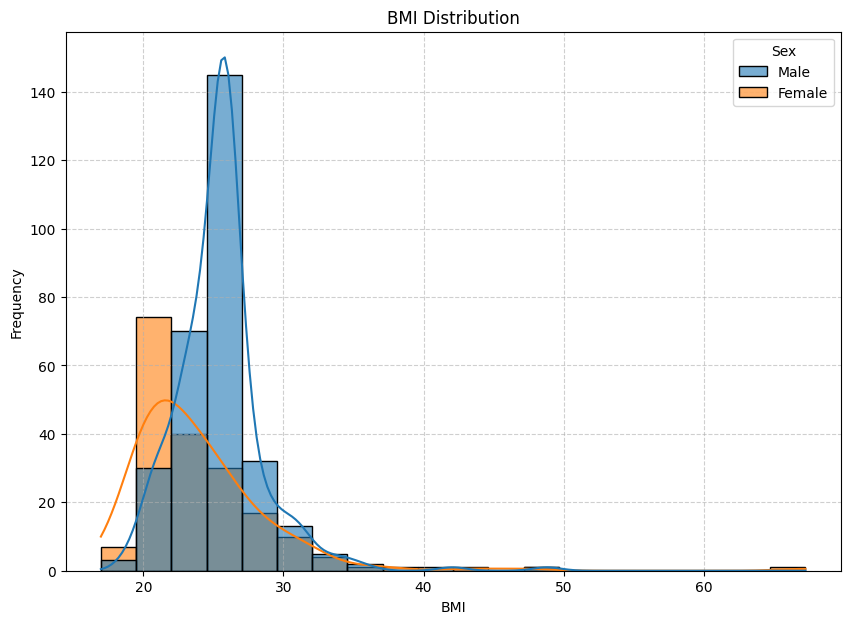

In [17]:
plot_kde(
    bmi,
    title="BMI Distribution",
    x_label="BMI",
    color_by_sex=sex
)

### Bacteria

In [10]:
def plot_feature_spans(df, sort_features=True):
    stats = np.array([df.mean(), df.min(), df.max()]).T

    if sort_features:
        stats = stats[stats[:, 0].argsort()]

    plt.figure(figsize=(15, 5))
    plt.scatter(
        range(len(stats)), stats[:, 0],
        marker="o", c='black', s=50,
        label="Mean",
        zorder=4
    )
    plt.vlines(
        range(len(stats)),
        stats[:, 1], stats[:, 2],
        color='blue', linestyle='-', lw=3, alpha=0.5,
        label="Min to Max"
    )
    plt.scatter(
        range(len(stats)), stats[:, 1],
        c='blue', s=25,
        label="Min",
        zorder=3
    )
    plt.scatter(
        range(len(stats)), stats[:, 2],
        c='blue', s=25,
        label="Max",
        zorder=3
    )
    plt.xlabel("Feature index")
    plt.ylabel("Values")
    plt.title("Sorted features by mean value")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()

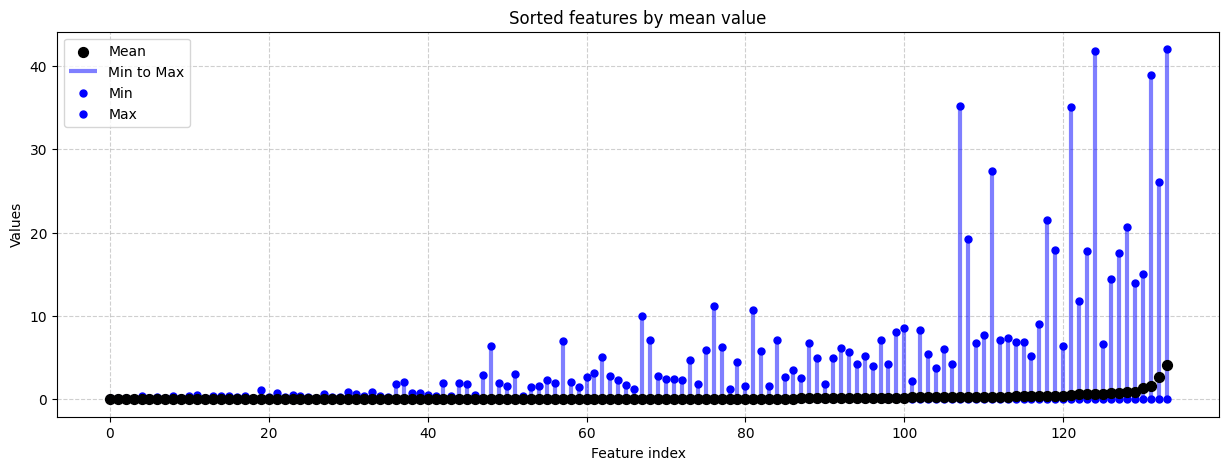

In [11]:
plot_feature_spans(bacteria)

### Sex and Age

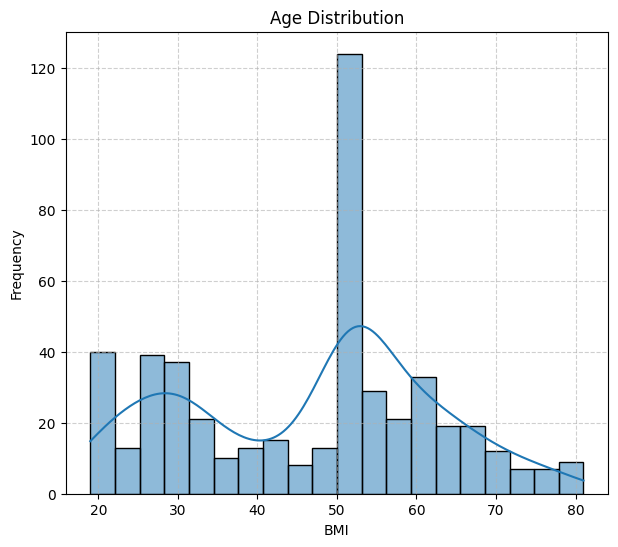

In [12]:
plot_kde(
    age,
    title="Age Distribution",
    x_label="BMI"
)

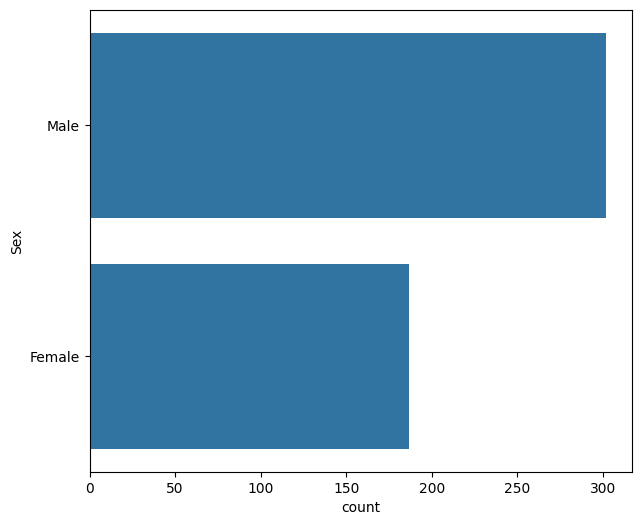

In [27]:
# Plot the number of males and females in the study
plt.figure(figsize=(7, 6))
sns.countplot(sex)
plt.show()